In [1]:
import pandas as pd
import cv2
import numpy as np
from sklearn.utils import shuffle
import os
from collections import deque
import copy
import matplotlib
import matplotlib.pyplot as plt
from config import Config
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
%matplotlib inline
tf.random.set_seed(42)

In [4]:
dirpath = "/home/chandu/Desktop/New_Frame/"
outpath = "/home/chandu/Desktop/New_Frame/CSV"
parent = sorted(Path(dirpath).iterdir(), key=os.path.getmtime)
dict_of_labels = {'Six':1,'Out':0,'Misshit':'0'}

for child in parent:
    label = str(child).split('/')[-1]
    print(label)
    if(label=="CSV"): continue
    if(os.path.isdir(str(child)) == False): continue
    video_file = sorted(Path(child).iterdir(), key=os.path.getmtime)
    for video in video_file:
        v = str(video).split('/')[-1]
        frames_list = sorted(Path(video).iterdir(), key=os.path.getmtime)
        data = {'FileName':[],'Label':[]}
        for frames in frames_list:
            data['FileName'].append(str(frames))
            data['Label'].append(dict_of_labels[label])
        
        data_frame = pd.DataFrame(data)
        path = outpath+'/{}_{}.csv'.format(label,v)
        data_frame.to_csv(path)

Out
Six
Misshit
generate_frames.ipynb
.ipynb_checkpoints


NotADirectoryError: [Errno 20] Not a directory: '/home/chandu/Desktop/New_Frame/.ipynb_checkpoints/generate_frames-checkpoint.ipynb'

In [2]:
# reading the video files from the csv file
def file_generator(data_path,data_files,temporal_stride=1,temporal_length=10):
    '''
    data_files - list of csv files to be read.
    '''
    for f in data_files: # read all the csv files (one csv file corresponds to one vdieo) in data_files one by one
        tmp_df = pd.read_csv(os.path.join(data_path,f))
        label_list = list(tmp_df['Label'])  # Load all the labels in the label_list
        total_images = len(label_list) 
        if total_images>=temporal_length: # only if the number of frames in the video is greater tha temporal length, use that video
            num_samples = int((total_images-temporal_length)/temporal_stride)+1
#             print ('num of samples from vid seq-{}: {}'.format(f,num_samples))
            img_list = list(tmp_df['FileName'])
        else: # if the number of frames are less than temporal length , discard it
            print ('num of frames is less than temporal length; hence discarding this file-{}'.format(f))
            continue

        start_frame = 0
        samples = deque() # initliaze a queue to store the frames 
        samp_count=0 # a counter to count the number of smaple. one smaple has as many frames as defined by temporal length
        for img in img_list:
            samples.append(img)
            if len(samples)==temporal_length: #if the queue has as many frames as temporal length, return it as one sample
                samples_c=copy.deepcopy(samples) # copy the queue as in the next stage frames would be popped
                samp_count+=1
                for t in range(temporal_stride): # pop out as many frames as described by the stride from the left to accomodate new frames
                    samples.popleft()
                yield samples_c,label_list[0] # return a sample(consisting of as many frames as defined by temporal length) 
                                                # and its corsponding label

In [3]:
# Load the samples and their corresponding label for each video
def load_samples(data_cat='train',temporal_stride=1,temporal_length=10):
    data_path = os.path.join('CSV',data_cat)
    data_files = os.listdir(data_path)
    # define a generator to read the samples
    file_gen = file_generator(data_path,data_files,temporal_stride,temporal_length)
    iterator = True
    data_list = []
    while iterator:
        try:
            x,y = next(file_gen)
            x=list(x)
            data_list.append([x,y])
        except Exception as e:
            print ('the exception: ',e)
            iterator = False
            print ('end of data generator')
    return data_list

In [4]:
all_data = load_samples(data_cat='all',temporal_stride=1,temporal_length=10)

num of frames is less than temporal length; hence discarding this file-Six_44.csv
the exception:  
end of data generator


In [5]:
len(all_data)

843

In [6]:
all_data = shuffle(all_data,random_state=123)

In [7]:
train_data, test_data = train_test_split(all_data,train_size =0.75, test_size=0.25,random_state=1234)

In [8]:
test_data, val_data = train_test_split(test_data,train_size =0.60, test_size=0.40,random_state=1234)

In [9]:
print(len(train_data),len(test_data),len(val_data))

632 126 85


In [10]:
def shuffle_data(samples):
    data = shuffle(samples)
    return data

In [11]:
def preprocess_image(img):
    img = cv2.resize(img,(224,224))
    img = img/255
    return img

In [12]:
def data_generator(data,batch_size=10,temporal_padding='same',shuffle=True):              
    """
    Yields the next training batch.
    data is an array [[img1_filename,img2_filename...,img16_filename],label1], [image2_filename,label2],...].
    """
    num_samples = len(data)
    if shuffle:
        data = shuffle_data(data)
#     while True:   
    for offset in range(0, num_samples, batch_size):
#         print ('startring index: ', offset) 
        # Get the samples you'll use in this batch
        batch_samples = data[offset:offset+batch_size]
        # Initialise X_train and y_train arrays for this batch
        X_train = []
        y_train = []
        # For each example
        for batch_sample in batch_samples: # Loop over every batch
            # Load image (X)
            x = batch_sample[0]
            y = batch_sample[1]
            temp_data_list = []
            for img in x:
                try:
                    img = cv2.imread(img)
                    #apply any kind of preprocessing here
                    #img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
                    img = preprocess_image(img)
                    img = tf.image.per_image_standardization(img)
                    temp_data_list.append(img)

                except Exception as e:
                    print (e)
                    print ('error reading file: ',img)                      
            # Read label (y)
            #label = label_names[y]
            # Add example to arrays
            X_train.append(temp_data_list)
            y_train.append(y)

        # Make sure they're numpy arrays (as opposed to lists)
        X_train = np.array(X_train)
        #X_train = np.rollaxis(X_train,1,4)
        y_train = np.array(y_train)
        # convert to one hot encoding for training keras model
        y_train = to_categorical(y_train, 2)

        # yield the next training batch            
        yield X_train, y_train

In [13]:
train_generator = data_generator(train_data,batch_size=4,shuffle=True)
val_generator = data_generator(val_data,batch_size=4,shuffle=True)
test_generator = data_generator(test_data,batch_size=1,shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

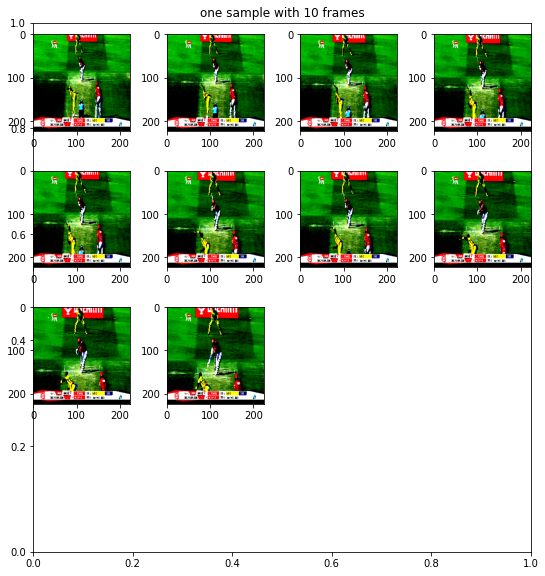

In [17]:
x_0 = next(test_generator)[0]
x_0 = x_0[0]
num_of_images = 10
fig = plt.figure(figsize=(8,8))
plt.title("one sample with {} frames".format(num_of_images))
subplot_num = int(np.ceil(np.sqrt(num_of_images)))
for i in range(num_of_images):
    ax = fig.add_subplot(subplot_num, subplot_num, i+1)
    ax.imshow(x_0[i,:,:,::-1])
    plt.tight_layout()
plt.show()

In [45]:
x_0[0][1].shape

(224, 3)

In [14]:
import tensorflow as tf

class MyModel(tf.keras.Model):

    def __init__(self):
        super(MyModel, self).__init__()
        self.vgg = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(224,224,3))
        self.dense1 = tf.keras.layers.Dense(512, activation=tf.nn.relu)
        self.LSTM = tf.keras.layers.LSTM(256 ,dropout=0.2,input_shape=(4,10,512))
        self.dense2 = tf.keras.layers.Dense(128,activation=tf.nn.relu)
        self.dropout = tf.keras.layers.Dropout(0.15)
        #new addition
        self.dense3 = tf.keras.layers.Dense(16,activation=tf.nn.relu)
        self.dropout2 = tf.keras.layers.Dropout(0.25)
        self.dense4 = tf.keras.layers.Dense(2)
        
    def call(self, inputs, training=False):
        #4*10*224*224*3
        embeddings = []
        for b in range(inputs.shape[0]):
            #embedding for all batches;
            tmp = self.vgg(inputs[b])
            tmp = tf.reshape(tmp, [10,-1])
            tmp = self.dense1(tmp)
            embeddings.append(tmp)
        x = tf.stack(embeddings)
        x = self.LSTM(x)
        x = self.dense2(x)
        x = self.dropout(x,training=training)
        x = self.dense3(x)
        x = self.dropout2(x,training=training)
        return self.dense4(x)
    
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

In [15]:
model = MyModel()

In [16]:
model.build(input_shape=(4,10,224,224,3))
model.summary(line_length=None, positions=None, print_fn=None)

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
dense (Dense)                multiple                  51380736  
_________________________________________________________________
lstm (LSTM)                  multiple                  787456    
_________________________________________________________________
dense_1 (Dense)              multiple                  32896     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  2064      
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0  

In [17]:
import copy as DeepCopy
def loss(actual, predicted):
    binary_crossentropy = tf.losses.binary_crossentropy(actual, predicted,from_logits=True)
    average_loss = tf.reduce_mean(binary_crossentropy)
    return average_loss

final_model = model
def train(train_data, val_data, test_data, epochs, learning_rate=1e-5, momentum=9e-1,decay=1e-6):
    val_accuracy = 0
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model = MyModel()
    model.layers[0].trainable = False
    final_model = model
    for epoch in range(epochs):
        epoch_loss = []
        train_accuracy = []
        validation_accuracy = []
        train_generator = data_generator(train_data,batch_size=4,shuffle=True)
        for train_batch in train_generator:
            train_batch_features, train_batch_labels = train_batch
#             validation_batch_features, validation_batch_labels = validation_batch

            with tf.GradientTape() as tape:
                predictions = model(train_batch_features,training=True)
                train_loss = loss(train_batch_labels, predictions)
                #print("train ",train_loss)
            gradients = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            epoch_loss.append(train_loss)

            accuracy = tf.metrics.Accuracy()
            accuracy(tf.argmax(train_batch_labels, 1),tf.argmax(predictions, 1))
            train_accuracy.append(accuracy.result())
#             print(tf.argmax(train_batch_labels, 1),tf.argmax(predictions, 1),predictions)
        val_generator = data_generator(val_data,batch_size=4,shuffle=True)
        for validation_batch in val_generator:
            validation_batch_features, validation_batch_labels = validation_batch
            validation_predictions = model(validation_batch_features,training=False)
            accuracy = tf.metrics.Accuracy()
            accuracy(tf.argmax(validation_batch_labels, 1),tf.argmax(validation_predictions, 1))
            validation_accuracy.append(accuracy.result())
        epoch_loss = tf.reduce_mean(epoch_loss)
        train_accuracy = tf.reduce_mean(train_accuracy)
        validation_accuracy = tf.reduce_mean(validation_accuracy)
        if(val_accuracy < validation_accuracy):
            val_accuracy = validation_accuracy
            final_model = DeepCopy.copy(model)
        print('Epoch {} / {} : train loss = {}, train accuracy = {}, val accuracy = {}'.format(epoch,epochs,epoch_loss,train_accuracy,val_accuracy))
    
    test_generator = data_generator(test_data,batch_size=1,shuffle=False)
    test_accuracy = []
    y_ = []
    y = []
    for test_batch in test_generator:
        test_batch_features, test_batch_labels = test_batch
        test_predictions = model(test_batch_features,training=False)
        accuracy = tf.metrics.Accuracy()
        accuracy(tf.argmax(test_batch_labels, 1),tf.argmax(test_predictions, 1))
        y_.append(tf.argmax(test_batch_labels, 1)[0].numpy())
        y.append(tf.argmax(test_predictions, 1)[0].numpy())
#         print(tf.argmax(test_batch_labels, 1),tf.argmax(test_predictions, 1),test_predictions)
        test_accuracy.append(accuracy.result())
    test_accuracy = tf.reduce_mean(test_accuracy)
    print('test accuracy = {}'.format(test_accuracy))
    print(tf.math.confusion_matrix(y_,y,num_classes = 2))
    return y_,y
    
    

In [25]:
y_,y = train(train_data,val_data,test_data,7)

Epoch 0 / 7 : train loss = 0.6967070698738098, train accuracy = 0.5348101258277893, val accuracy = 0.5340909361839294
Epoch 1 / 7 : train loss = 0.6663556694984436, train accuracy = 0.6155063509941101, val accuracy = 0.5568181872367859
Epoch 2 / 7 : train loss = 0.6357195377349854, train accuracy = 0.6772152185440063, val accuracy = 0.5568181872367859
Epoch 3 / 7 : train loss = 0.5972180962562561, train accuracy = 0.7088607549667358, val accuracy = 0.5568181872367859
Epoch 4 / 7 : train loss = 0.5534091591835022, train accuracy = 0.7484177350997925, val accuracy = 0.5568181872367859
Epoch 5 / 7 : train loss = 0.5180509686470032, train accuracy = 0.7484177350997925, val accuracy = 0.5568181872367859
Epoch 6 / 7 : train loss = 0.43202435970306396, train accuracy = 0.8496835231781006, val accuracy = 0.5568181872367859
test accuracy = 0.5079365372657776
tf.Tensor(
[[18 37]
 [25 46]], shape=(2, 2), dtype=int32)


In [26]:
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()

In [27]:
recall.update_state(y_,y)
precision.update_state(y_,y)
r = recall.result().numpy()
p = precision.result().numpy()

In [28]:
f1 = 2*(r*p)/(r+p)

In [29]:
f1

0.5974026031980821

In [30]:
r

0.64788735

In [31]:
p

0.55421686

In [5]:
config = tf.keras.ConfigProto(allow_soft_placement = True)

AttributeError: module 'tensorflow.keras' has no attribute 'ConfigProto'